In [8]:
import numpy as np
import pandas as pd
import pickle
import torch
import sys
import matplotlib.pyplot as plt
from matplotlib import cm,colors
from warnings import filterwarnings
from tqdm import tqdm
import seaborn as sns
from torch import nn
import os
import bioframe
import anndata
from argparse import Namespace
import json

filterwarnings('ignore')
sys.path.append('/home/che/perturb-project/git/gene_ptb_prediction/src')

import scanpy as sc
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import pytorch_lightning as pl

In [9]:
from inference import *
from utils import SCDATA_sampler, MMD_loss
from dataset import SCDataset
from torch.utils.data import DataLoader

In [10]:
# set random seed
rand_seed = 12
pl.seed_everything(rand_seed)
use_gears_top_20 = False
adata_file_path = '/home/che/perturb-project/git/gene_ptb_prediction/scdata_file_path.csv'
device = 'cuda:3'

Seed set to 12


In [11]:
# Specify the dataset name and the test set name
dataset_name = 'replogle_k562_essential' # 'dixit_bmdc_3hr' or 'replogle_k562_essential' or 'replogle_rpe1
use_hvg = True
test_set_name = 'random_fold_1'

if use_hvg:
    dataset_str = f'{dataset_name}_hvg'
else:
    dataset_str = dataset_name

In [12]:
opts = Namespace(
    dataset_name = dataset_name,
    use_hvg = use_hvg,
    test_set_name = test_set_name,
    recon_loss = 'mmd',
    null_label = 'zeros',
    epochs = 100,
    tolerance_epochs = 20,
    mxAlpha = 2.0,
    validation_set_ratio = 0.1,
    validation_ood_ratio = 0.15,
    latdim_ctrl=50,
    latdim_ptb=50,
    geneset_num=50,
    random_seed = rand_seed,
    model_name = 'best_model.pt' # best_model.pt or best_model_val.pt
)

savedir = (f'/home/che/perturb-project/predict_model/result/rna/{dataset_str}/'
           f'latdim_ctrl_{opts.latdim_ctrl}_latdim_ptb_{opts.latdim_ptb}_geneset_num_{opts.geneset_num}/{test_set_name}/recon_loss_{opts.recon_loss}/'
           f'null_label_{opts.null_label}/epochs_{opts.epochs}/tolerance_epochs_{opts.tolerance_epochs}/mxAlpha_{opts.mxAlpha}/'
           f'val_{opts.validation_set_ratio}_ood_{opts.validation_ood_ratio}/'
           f'random_seed_{opts.random_seed}/DepMap_GeneEffect_mvae_attention_vae_14_2_run1739678684'
)

opts.savedir = savedir
opts.model_id = savedir.split('/')[-1]
opts.model_id

'DepMap_GeneEffect_mvae_attention_vae_14_2_run1739678684'

### Gene program exploration

In this script, we are trying to see if we can get the similar gene sets to those identified in the original paper (Replogle or Dixit) by analyzing the attention maps and the program to gene mappings. 

In [13]:
# load in raw data
adata_file = pd.read_csv(adata_file_path)
adata_path = adata_file[(adata_file['dataset'] == dataset_name) & (adata_file['use_hvg'] == use_hvg)]['file_path'].values[0]
adata = sc.read(adata_path)
print('Read adata from', adata_path)

Read adata from /home/che/perturb-project/predict_model/dataset/replogle_k562/K562_essential_normalized_hvg.h5ad


### Step 1. Load trained model

In [14]:
assert test_set_name in opts.savedir
assert dataset_name in opts.savedir
print(test_set_name)
model = torch.load(f'{opts.savedir}/{opts.model_name}', map_location=device) if opts.savedir is not None else None
model.eval()
print('Loaded model from', f'{opts.savedir}/{opts.model_name}')

random_fold_1
Loaded model from /home/che/perturb-project/predict_model/result/rna/replogle_k562_essential_hvg/latdim_ctrl_50_latdim_ptb_50_geneset_num_50/random_fold_1/recon_loss_mmd/null_label_zeros/epochs_100/tolerance_epochs_20/mxAlpha_2.0/val_0.1_ood_0.15/random_seed_12/DepMap_GeneEffect_mvae_attention_vae_14_2_run1739678684/best_model.pt


In [15]:
result_dir = f"{opts.savedir}/{opts.model_name.split('.')[0]}"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
print(result_dir)

/home/che/perturb-project/predict_model/result/rna/replogle_k562_essential_hvg/latdim_ctrl_50_latdim_ptb_50_geneset_num_50/random_fold_1/recon_loss_mmd/null_label_zeros/epochs_100/tolerance_epochs_20/mxAlpha_2.0/val_0.1_ood_0.15/random_seed_12/DepMap_GeneEffect_mvae_attention_vae_14_2_run1739678684/best_model


In [16]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
# Print the total number of parameters
print(f'Total number of parameters: {total_params}')

Total number of parameters: 3485876


In [17]:
import json
with open(f'{savedir}/config.json', 'rb') as f:
    config = json.load(f)

mmd_sigma = config['MMD_sigma']

if dataset_name == 'replogle_k562_essential':
    distance_to_ctrl_path = f'/home/che/perturb-project/predict_model/dataset/replogle_k562/replogle_k562_essential_hvg_mmd_distance_{mmd_sigma}_to_non-targeting.csv'
elif dataset_name == 'replogle_rpe1':
    distance_to_ctrl_path = '/home/che/perturb-project/predict_model/dataset/replogle_rpe1/replogle_rpe1_hvg_mmd_distance_to_non-targeting.csv'
elif dataset_name == 'dixit_bmdc_3hr':
    distance_to_ctrl_path = f'/home/che/perturb-project/predict_model/dataset/dixit_2016/dixit_bmdc_3hr_hvg_mmd_distance_{mmd_sigma}_to_non-targeting.csv'

distance_to_ctrl = pd.read_csv(distance_to_ctrl_path, index_col=0)
assert mmd_sigma == distance_to_ctrl['mmd_sigma'].values[0]
distance_to_ctrl.head(5)

,ptb_gene,mean_mmd_distance,std_mmd_distance,data_size,mmd_sigma
anchor_gene,,,,,
non-targeting,non-targeting,0.367839,0.006777,10688,1500
non-targeting,RPL3,0.371874,0.006166,1984,1500
non-targeting,NCBP2,0.472058,0.023673,992,1500
non-targeting,KIF11,0.371297,0.006186,960,1500
non-targeting,SLC39A9,0.378448,0.005083,736,1500


### Step 2. Get the attention maps of the trained model

In [18]:
from torch.utils.data import DataLoader, Subset

print('null vector type:', config['null_label'])
print('mxAlpha:', config['mxAlpha'])

with open(f'{savedir}/split_idx.pkl', 'rb') as f:
    split_idx = pickle.load(f)
    train_idx = split_idx['train_idx']
    val_idx = split_idx['val_idx']
    infer_idx = split_idx['infer_idx']

dataset = SCDataset(modality='rna',
                    dataset = config['dataset'], 
                    leave_out_test_set_id = config['leave_out_test_set_id'],
                    perturb_targets=None, 
                    representation_type=config['label'], 
                    representation_type_2 = config['label_2'],
                    representation_type_3=config['label_3'],
                    min_counts=config['batch_size'],
                    use_hvg=config['use_hvg'],
                    random_seed=config['seed'],
                    gene_embs=None)

null vector type: zeros
mxAlpha: 2.0
Loading perturbation target embeddings from /home/che/perturb-project/data/gene_ptb_emb/DepMap/depmap_crispr_gene_effect_name_correct.pkl
loading split data from:  /home/che/perturb-project/git/gene_ptb_prediction/performance_eval/rna_data/replogle_k562_essential_hvg/splits.csv
leave_out_test_set_id:  random_fold_1
Loaded adata from:  /home/che/perturb-project/predict_model/dataset/replogle_k562/K562_essential_normalized_hvg.h5ad
Length of raw ptb_leave_out_list:  407
Length of filtered ptb_leave_out_list (after removing gene with counts <  32 ):  407
Checking for perturbation targets without embeddings in adata...
Perturbation targets without embeddings:  ['RPS27', 'RPS26', 'TIMM23B', 'CDK11A', 'NBPF12', 'KRTAP4-7', 'OR4F4', 'SMN2', 'FAM72D', 'FRG2', 'CASP8AP2', 'CCDC144NL', 'ALG1L', 'PLA2G10', 'SPDYE2', 'OR2A1', 'HIST2H2AA3', 'EIF3CL', 'GOLGA6L1', 'GTF2H2C', 'C14orf178', 'ARHGAP11B', 'NOMO3', 'LCE1C', 'POLR2A', 'NBPF15', 'RPS10-NUDT3', 'GTF2H2', '

In [19]:
# All dataloader
if infer_idx is not None:
    all_idx = np.concatenate([train_idx, val_idx, infer_idx])
else:
    all_idx = np.concatenate([train_idx, val_idx])
dataset_all = Subset(dataset, all_idx)
all_ptb_name = dataset.ptb_names[all_idx]
dataloader = DataLoader(
    dataset_all,
    batch_sampler=SCDATA_sampler(dataset_all, config['batch_size'], all_ptb_name),
    num_workers=0
)

In [20]:
# list of ptb targets in test set
ptb_leave_out_list = dataset.ptb_leave_out_list
if infer_idx is not None:
    infer_ptb_name = dataset.ptb_names[infer_idx]
    assert set(infer_ptb_name) == set(ptb_leave_out_list)
    assert len(set(infer_ptb_name)) == len(ptb_leave_out_list)
print('There are', len(ptb_leave_out_list), 'perturbations in the test set')

There are 402 perturbations in the test set


In [21]:
assert(config['MMD_sigma'] == mmd_sigma)
mmd_loss_function = MMD_loss(fix_sigma=mmd_sigma, kernel_num=config['kernel_num'])
print('mmd sigma:', mmd_sigma, 'kernel_num:', config['kernel_num'])

mmd sigma: 1500 kernel_num: 10


### Step 2.1 Get attention maps for perturbation targets

In [22]:
model = model.to(device)
model.eval()

alpha_1_ptb_dict = {}
alpha_2_ptb_dict = {}

alpha_1_ctrl_dict = {}
alpha_2_ctrl_dict = {}

alpha_1_diff_dict = {}
alpha_2_diff_dict = {}

q_1_ctrl_dict = {}
q_1_ptb_dict = {}
q_2_ctrl_dict = {}
q_2_ptb_dict = {}

pred_y_dict = {}

for (i, X) in tqdm(enumerate(dataloader), total=len(dataloader), desc='Getting attention maps for all samples'):
    x = X[0] #control samples
    y = X[1] #perturbation samples
    c_1 = X[2] #perturbation labels (target 1)
    c_2 = X[3] #perturbation labels (target 2)
    gene_ptb = np.unique(X[4])[0] #perturbation gene

    x = x.to(device)
    c_1 = c_1.to(device)
    c_2 = c_2.to(device)

    with torch.no_grad():
        y_hat, _, _, _, alphas = model(x,c_1, c_2, num_interv=2, return_alphas=True)

    alphas_1_ptb = alphas[0].cpu().numpy()
    alphas_2_ptb = alphas[1].cpu().numpy() if alphas[1] is not None else None
    alphas_1_ctrl = alphas[2].cpu().numpy()
    alphas_2_ctrl = alphas[3].cpu().numpy() if alphas[3] is not None else None
    q_1_ptb = alphas[4].cpu().numpy()
    q_1_ctrl = alphas[5].cpu().numpy()
    q_2_ptb = alphas[8].cpu().numpy()
    q_2_ctrl = alphas[9].cpu().numpy()
    alphas_1_diff = alphas_1_ptb - alphas_1_ctrl
    alphas_2_diff = alphas_2_ptb - alphas_2_ctrl if alphas_2_ptb is not None else None

    del alphas

    # Get the attention maps ---------------------------------------------------------
    if gene_ptb not in alpha_1_ptb_dict:
        alpha_1_ptb_dict[gene_ptb] = alphas_1_ptb
        alpha_2_ptb_dict[gene_ptb] = alphas_2_ptb if alphas_2_ptb is not None else None
        alpha_1_ctrl_dict[gene_ptb] = alphas_1_ctrl
        alpha_2_ctrl_dict[gene_ptb] = alphas_2_ctrl if alphas_2_ctrl is not None else None
        alpha_1_diff_dict[gene_ptb] = alphas_1_diff
        alpha_2_diff_dict[gene_ptb] = alphas_2_diff if alphas_2_diff is not None else None
        pred_y_dict[gene_ptb] = y_hat.cpu().numpy()
        q_1_ctrl_dict[gene_ptb] = q_1_ctrl
        q_1_ptb_dict[gene_ptb] = q_1_ptb
        q_2_ctrl_dict[gene_ptb] = q_2_ctrl
        q_2_ptb_dict[gene_ptb] = q_2_ptb

    else:
        alpha_1_ptb_dict[gene_ptb] = np.concatenate((alpha_1_ptb_dict[gene_ptb], alphas_1_ptb), axis=0)
        alpha_2_ptb_dict[gene_ptb] = np.concatenate((alpha_2_ptb_dict[gene_ptb], alphas_2_ptb), axis=0) if alphas_2_ptb is not None else None
        alpha_1_ctrl_dict[gene_ptb] = np.concatenate((alpha_1_ctrl_dict[gene_ptb], alphas_1_ctrl), axis=0)
        alpha_2_ctrl_dict[gene_ptb] = np.concatenate((alpha_2_ctrl_dict[gene_ptb], alphas_2_ctrl), axis=0) if alphas_2_ctrl is not None else None
        alpha_1_diff_dict[gene_ptb] = np.concatenate((alpha_1_diff_dict[gene_ptb], alphas_1_diff), axis=0)
        alpha_2_diff_dict[gene_ptb] = np.concatenate((alpha_2_diff_dict[gene_ptb], alphas_2_diff), axis=0) if alphas_2_diff is not None else None
        pred_y_dict[gene_ptb] = np.concatenate((pred_y_dict[gene_ptb], y_hat.cpu().numpy()), axis=0)
        q_1_ctrl_dict[gene_ptb] = np.concatenate((q_1_ctrl_dict[gene_ptb], q_1_ctrl), axis=0)
        q_1_ptb_dict[gene_ptb] = np.concatenate((q_1_ptb_dict[gene_ptb], q_1_ptb), axis=0)
        q_2_ctrl_dict[gene_ptb] = np.concatenate((q_2_ctrl_dict[gene_ptb], q_2_ctrl), axis=0)
        q_2_ptb_dict[gene_ptb] = np.concatenate((q_2_ptb_dict[gene_ptb], q_2_ptb), axis=0)

Getting attention maps for all samples: 100%|██████████| 8283/8283 [00:47<00:00, 175.54it/s]


In [23]:
alpha_1_ptb_avg_dict = {k: np.mean(v, axis=0) for k, v in alpha_1_ptb_dict.items()}
alpha_1_ctrl_avg_dict = {k: np.mean(v, axis=0) for k, v in alpha_1_ctrl_dict.items()}
alpha_1_ptb_diff_avg_dict = {k: np.mean(v, axis=0) for k, v in alpha_1_diff_dict.items()}
alpha_2_ptb_avg_dict = {k: np.mean(v, axis=0) for k, v in alpha_2_ptb_dict.items() if v is not None}
alpha_2_ctrl_avg_dict = {k: np.mean(v, axis=0) for k, v in alpha_2_ctrl_dict.items() if v is not None}
alpha_2_ptb_diff_avg_dict = {k: np.mean(v, axis=0) for k, v in alpha_2_diff_dict.items() if v is not None}
len(alpha_1_ptb_avg_dict), len(alpha_1_ptb_diff_avg_dict), len(alpha_2_ptb_avg_dict), len(alpha_2_ptb_diff_avg_dict)
assert len(alpha_2_ptb_avg_dict) == len(set(dataset.ptb_names))

In [24]:
# get the attention tables
alpha_1_ptb_avg_df = pd.DataFrame({key: value.flatten() for key, value in alpha_1_ptb_avg_dict.items()}).T
alpha_1_ctrl_avg_df = pd.DataFrame({key: value.flatten() for key, value in alpha_1_ctrl_avg_dict.items()}).T
alpha_1_ptb_diff_avg_df = pd.DataFrame({key: value.flatten() for key, value in alpha_1_ptb_diff_avg_dict.items()}).T
alpha_1_ptb_diff_avg_df_abs = alpha_1_ptb_diff_avg_df.abs() # get absolute values of the difference

alpha_2_ptb_avg_df = pd.DataFrame({key: value.flatten() for key, value in alpha_2_ptb_avg_dict.items() if value is not None}).T if len(alpha_2_ptb_avg_dict) > 0 else None
alpha_2_ctrl_avg_df = pd.DataFrame({key: value.flatten() for key, value in alpha_2_ctrl_avg_dict.items() if value is not None}).T if len(alpha_2_ctrl_avg_dict) > 0 else None
alpha_2_ptb_diff_avg_df = pd.DataFrame({key: value.flatten() for key, value in alpha_2_ptb_diff_avg_dict.items() if value is not None}).T if len(alpha_2_ptb_diff_avg_dict) > 0 else None
alpha_2_ptb_diff_avg_df_abs = alpha_2_ptb_diff_avg_df.abs() if alpha_2_ptb_diff_avg_df is not None else None # get absolute values of the difference

# average the attention maps
alpha_avg_df = (alpha_1_ptb_avg_df + alpha_2_ptb_avg_df) / 2 if alpha_2_ptb_avg_df is not None else alpha_1_ptb_avg_df
alpha_diff_avg_df = (alpha_1_ptb_diff_avg_df + alpha_2_ptb_diff_avg_df) / 2 if alpha_2_ptb_diff_avg_df is not None else alpha_1_ptb_diff_avg_df

assert alpha_1_ptb_avg_df.shape == alpha_1_ptb_diff_avg_df.shape == alpha_2_ptb_avg_df.shape == alpha_2_ptb_diff_avg_df.shape
assert alpha_1_ptb_avg_df.shape == alpha_avg_df.shape
assert alpha_1_ptb_avg_df.shape == alpha_diff_avg_df.shape

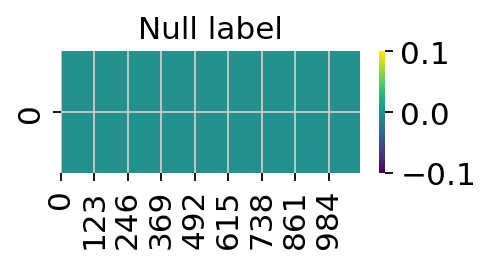

In [25]:
null_label = model.null_label.cpu().numpy()
# plot heatmap of null_label
plt.figure(figsize=(3, 1))
sns.heatmap(null_label.reshape(1, -1), cmap='viridis')
plt.title('Null label')
plt.show()

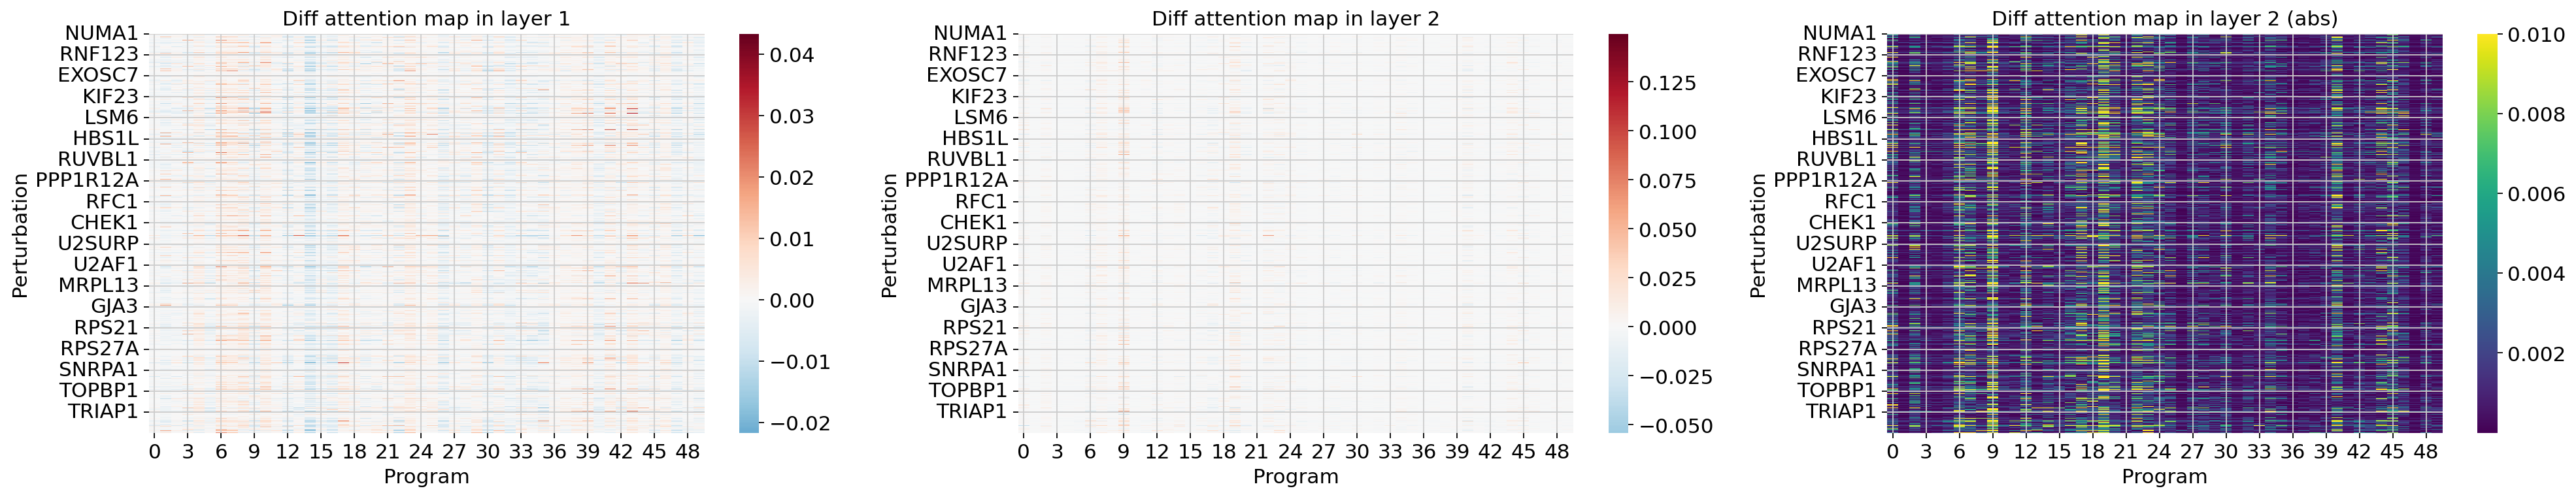

In [26]:
# Set the figure size to accommodate two plots side by side
plt.figure(figsize=(25, 5))

# Plot the heatmap for layer 2
plt.subplot(1, 3, 1)  # 1 row, 2 columns, position 2
sns.heatmap(alpha_1_ptb_diff_avg_df, cmap='RdBu_r', center=0)
plt.title('Diff attention map in layer 1')
plt.xlabel('Program')
plt.ylabel('Perturbation')

# Plot the heatmap for layer 2
plt.subplot(1, 3, 2)  # 1 row, 2 columns, position 2
sns.heatmap(alpha_2_ptb_diff_avg_df, cmap='RdBu_r',center=0)
plt.title('Diff attention map in layer 2')
plt.xlabel('Program')
plt.ylabel('Perturbation')

# Plot the heatmap for layer 2
plt.subplot(1, 3, 3)  # 1 row, 2 columns, position 2
sns.heatmap(alpha_2_ptb_diff_avg_df_abs, cmap='viridis', vmax=0.01)
plt.title('Diff attention map in layer 2 (abs)')
plt.xlabel('Program')
plt.ylabel('Perturbation')

# Show the plots
plt.tight_layout()
plt.show()

In [27]:
# sum the alpha 2 diff maps for each target gene
alpha_ptb_diff_avg_abs_all = alpha_1_ptb_diff_avg_df.abs()
alpha_ptb_diff_avg_df_abs_sum = alpha_ptb_diff_avg_abs_all.sum(axis=1)
alpha_ptb_diff_avg_df_abs_sum.sort_values(ascending=False, inplace=True)
# append train-test split into alpha_2_ptb_diff_avg_df_abs_sum
alpha_ptb_diff_avg_df_abs_sum = alpha_ptb_diff_avg_df_abs_sum.to_frame()
alpha_ptb_diff_avg_df_abs_sum.columns = ['sum_abs_diff']
alpha_ptb_diff_avg_df_abs_sum['train_test'] = 'train'
alpha_ptb_diff_avg_df_abs_sum.loc[alpha_ptb_diff_avg_df_abs_sum.index.isin(ptb_leave_out_list), 'train_test'] = 'test'

print(alpha_ptb_diff_avg_df_abs_sum.head(5)) # these are the target genes that have the most different attention maps compared to control
print(alpha_ptb_diff_avg_df_abs_sum['train_test'].value_counts())

if len(ptb_leave_out_list) > 0: 
    assert alpha_ptb_diff_avg_df_abs_sum['train_test'].value_counts()['test'] == len(ptb_leave_out_list)

        sum_abs_diff train_test
SUPT5H      0.563796      train
MED9        0.536911      train
MED30       0.526351      train
INTS2       0.523877      train
MED12       0.499025      train
train_test
train    1591
test      402
Name: count, dtype: int64


In [28]:
# append attention values for ptb targets to distance_to_ctrl
distance_to_ctrl = distance_to_ctrl[distance_to_ctrl['ptb_gene'].isin(alpha_ptb_diff_avg_df_abs_sum.index)]
distance_to_ctrl['attention_diff'] = alpha_ptb_diff_avg_df_abs_sum.loc[distance_to_ctrl['ptb_gene']]['sum_abs_diff'].values
distance_to_ctrl['train_test'] = alpha_ptb_diff_avg_df_abs_sum.loc[distance_to_ctrl['ptb_gene']]['train_test'].values
alpha_ptb_diff_avg_df_abs_sum_train_test_ctrl = distance_to_ctrl.copy()
alpha_ptb_diff_avg_df_abs_sum_train_test_ctrl.head()

,ptb_gene,mean_mmd_distance,std_mmd_distance,data_size,mmd_sigma,attention_diff,train_test
anchor_gene,,,,,,,
non-targeting,RPL3,0.371874,0.006166,1984,1500,0.038959,train
non-targeting,NCBP2,0.472058,0.023673,992,1500,0.295375,test
non-targeting,KIF11,0.371297,0.006186,960,1500,0.034741,train
non-targeting,SLC39A9,0.378448,0.005083,736,1500,0.048990,test
non-targeting,DONSON,0.413104,0.013305,736,1500,0.207089,train


Correlation between attention_diff and mean_mmd_distance (train): 0.82, p-value: 0.00000
Correlation between attention_diff and mean_mmd_distance (test): 0.53, p-value: 0.00000


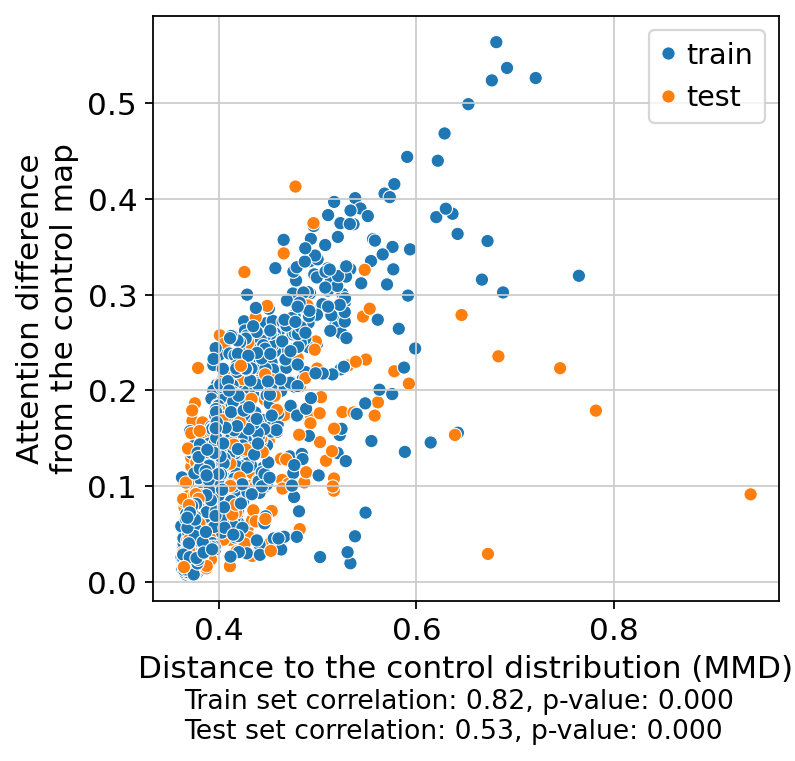

In [29]:
train_correlation, train_pval = pearsonr(alpha_ptb_diff_avg_df_abs_sum_train_test_ctrl[alpha_ptb_diff_avg_df_abs_sum_train_test_ctrl['train_test'] == 'train']['mean_mmd_distance'],
                                            alpha_ptb_diff_avg_df_abs_sum_train_test_ctrl[alpha_ptb_diff_avg_df_abs_sum_train_test_ctrl['train_test'] == 'train']['attention_diff'])
print(f'Correlation between attention_diff and mean_mmd_distance (train): {train_correlation:.2f}, p-value: {train_pval:.5f}')

if len(ptb_leave_out_list) > 0:
    test_correlation, test_pval = pearsonr(alpha_ptb_diff_avg_df_abs_sum_train_test_ctrl[alpha_ptb_diff_avg_df_abs_sum_train_test_ctrl['train_test'] == 'test']['mean_mmd_distance'],
                                            alpha_ptb_diff_avg_df_abs_sum_train_test_ctrl[alpha_ptb_diff_avg_df_abs_sum_train_test_ctrl['train_test'] == 'test']['attention_diff'])
    print(f'Correlation between attention_diff and mean_mmd_distance (test): {test_correlation:.2f}, p-value: {test_pval:.5f}')
else:
    test_correlation = None
    test_pval = None

# plot the correlation between attention_diff and mean_mmd_distance
plt.figure(figsize=(5.2, 5))
sns.scatterplot(x='mean_mmd_distance', y='attention_diff', data=alpha_ptb_diff_avg_df_abs_sum_train_test_ctrl, hue='train_test')
plt.xlabel('Distance to the control distribution (MMD)')
plt.ylabel('Attention difference\nfrom the control map')
# plt.title('Relationship between attention maps\nand MMD distance')
plt.legend(loc='upper right', title='')
if test_correlation is not None:
    plt.text(0.05, -0.15, f'Train set correlation: {train_correlation:.2f}, p-value: {train_pval:.3f}\nTest set correlation: {test_correlation:.2f}, p-value: {test_pval:.3f}', 
             ha='left', va='top', transform=plt.gca().transAxes, fontsize=12, color='black')
else:
    plt.text(0.05, -0.15, f'Train set correlation: {train_correlation:.2f}, p-value: {train_pval:.3f}', 
             ha='left', va='top', transform=plt.gca().transAxes, fontsize=12, color='black')
plt.tight_layout()
plt.savefig(f"{result_dir}/{opts.model_name.replace('.pt', '')}_alpha_ptb_diff_attention_diff_vs_mean_mmd_distance.png")
plt.savefig(f"{result_dir}/{opts.model_name.replace('.pt', '')}_alpha_ptb_diff_attention_diff_vs_mean_mmd_distance.svg", format='svg')
plt.show()

### Step 3. Perturb the attention maps to learn a mapping from gene programs to genes

Perturb the attention map to learn about the mapping from gene program to genes

In [30]:
geneset_num = model.geneset_num
print('geneset_num:', geneset_num)

geneset_num: 50


In [31]:
# now, loop through the gene program and try to get the genes that alter most
# when perturbing the attention at each gene program
program_gene_df = pd.DataFrame()

for i in range(geneset_num):
    with torch.no_grad():
        # set the attention at i to 1 and the rest to 0
        alpha_ptb = torch.zeros(1, geneset_num)
        alpha_ptb[0, i] = 1
        alpha_ptb = alpha_ptb.double().to(device)
        
        V1 = model.W_V1(model.geneset_mtrx)
        attn_out_1 = torch.mm(alpha_ptb, V1)
        z = attn_out_1
        z = model.FF1(z) + z

        attn_out_2, alphas_2, q_2, k_2, v_2 = model.attention_2(query=z, gene_set_matrix=model.geneset_mtrx)
        z = attn_out_2 + z
        z = model.FF2(z) + z
        gene_ptb = model.decode(z)
    
    gene_ptb_df = pd.DataFrame(gene_ptb.cpu().numpy().flatten(), columns=[i])
    gene_ptb_df = gene_ptb_df.T
    program_gene_df = pd.concat([program_gene_df, gene_ptb_df])

if dataset_name == 'replogle_k562_essential' or dataset_name == 'replogle_rpe1':
    program_gene_df.columns = adata.var['gene_name']
elif dataset_name == 'dixit_bmdc_3hr':
    program_gene_df.columns = adata.var_names

### Step 4. Load the gene modules identified in the original paper

In [32]:
if 'replogle_k562_essential' in dataset_name or 'replogle_rpe1' in dataset_name:
    # Get the perturbation clusters
    ptb_cluster = pd.read_csv('/home/che/perturb-project/git/gene_ptb_prediction/grn/gene_clusters/replogle/perturbation_clusters.csv')
    # subset to columns members and best_description
    ptb_cluster = ptb_cluster[['members', 'best_description']]
    # rename columns
    ptb_cluster.columns = ['gene_name', 'perturbation_cluster']
    # ptb_cluster['perturbation_cluster'] = ptb_cluster['perturbation_cluster'].apply(lambda x: np.nan if 'unknown' in str(x) else x)
    ptb_cluster = ptb_cluster[ptb_cluster['gene_name'].isin(alpha_1_ptb_avg_df.index)]
elif dataset_name == 'dixit_bmdc_3hr':
    ptb_cluster = pd.read_csv('/home/che/perturb-project/git/gene_ptb_prediction/grn/gene_clusters/dixit/fig4b_ptb_modules_dc3hr.csv')
    ptb_cluster = ptb_cluster[['gene_name', 'perturbation_cluster']]
    ptb_cluster = ptb_cluster[ptb_cluster['gene_name'].isin(alpha_1_ptb_avg_df.index)]

ptb_cluster['gene_name'] = ptb_cluster['gene_name'].str.lower()
ptb_cluster

,gene_name,perturbation_cluster
11,exoc5,unknown 3
24,cbll1,m6A mRNA methylation
25,mettl14,m6A mRNA methylation
26,mettl3,m6A mRNA methylation
27,psmg1,m6A mRNA methylation
...,...,...
700,vars,"mitochondrial protein translocation, tRNA synt..."
701,mrps21,"28S ribosomal subunit, mitochondrial"
702,mrps23,"28S ribosomal subunit, mitochondrial"
703,mrps28,"28S ribosomal subunit, mitochondrial"


In [33]:
#  filter to the perturbation clusters with size >= 10
threshold = 10
if dataset_name == 'replogle_k562_essential' or dataset_name == 'replogle_rpe1':
    print(f'get perturbation clusters with size >= {threshold}')
    ptb_cluster_greater_than_10 = ptb_cluster['perturbation_cluster'].value_counts()[ptb_cluster['perturbation_cluster'].value_counts() >= threshold].index
    ptb_cluster = ptb_cluster[ptb_cluster['perturbation_cluster'].isin(ptb_cluster_greater_than_10)]
    ptb_cluster['perturbation_cluster'].nunique()

get perturbation clusters with size >= 10


In [34]:
# first get the information from paper
if 'replogle_k562_essential' in dataset_name or 'replogle_rpe1' in dataset_name:
    gene_cluster = pd.read_csv('/home/che/perturb-project/git/gene_ptb_prediction/grn/gene_clusters/replogle/gene_expression_clusters.csv')
    gene_cluster = gene_cluster[['members', 'cluster_name', 'manual_annotation']]
    # rename columns
    gene_cluster.columns = ['gene_name', 'gene_cluster', 'manual_annotation']
    # drop NA in gene_cluster
    gene_cluster = gene_cluster.dropna(subset=['gene_cluster'])
    gene_cluster = gene_cluster[gene_cluster['gene_name'].isin(program_gene_df.columns)]
elif dataset_name == 'dixit_bmdc_3hr':
    gene_cluster = pd.read_csv('/home/che/perturb-project/git/gene_ptb_prediction/grn/gene_clusters/dixit/fig4a_genenames_programs_dc3hr.csv')
    gene_cluster = gene_cluster.melt(var_name='gene_cluster', value_name='gene_name')
    gene_cluster = gene_cluster.dropna(subset=['gene_name'])

gene_cluster['gene_name'] = gene_cluster['gene_name'].str.lower()
gene_cluster

,gene_name,gene_cluster,manual_annotation
0,mt-nd6,0_mitochondrial respiratory chain,mitochondrial respiratory chain
3,mt-nd2,0_mitochondrial respiratory chain,mitochondrial respiratory chain
4,mt-nd5,0_mitochondrial respiratory chain,mitochondrial respiratory chain
5,mt-co1,0_mitochondrial respiratory chain,mitochondrial respiratory chain
6,mt-nd3,0_mitochondrial respiratory chain,mitochondrial respiratory chain
...,...,...,...
1173,thap7,37_,NaN
1176,sdhaf3,37_,NaN
1178,rpf2,37_,NaN
1183,smim30,37_,NaN


In [35]:
# load in relationship between perturbation modules and gene clusters
if 'replogle_k562_essential' in dataset_name or 'replogle_rpe1' in dataset_name:
    raw_file_path = '/home/che/perturb-project/git/gene_ptb_prediction/grn/gene_clusters/replogle/perturbation_clusters.csv'
    raw_data_ptb= pd.read_csv(raw_file_path)
    ptb_to_cluster = raw_data_ptb[['best_description', 'strong_positive_gene_expr_clusters', 'strong_negative_gene_expr_clusters']]

    print('subset to those in ptb_cluster')
    ptb_to_cluster = ptb_to_cluster[ptb_to_cluster['best_description'].isin(ptb_cluster['perturbation_cluster'])]
    print(ptb_to_cluster['best_description'].nunique())

elif dataset_name == 'dixit_bmdc_3hr':
    raw_file_path = '/home/che/perturb-project/git/gene_ptb_prediction/grn/gene_clusters/dixit/fig4b_regulation_dc3r.csv'
    ptb_to_cluster = pd.read_csv(raw_file_path)
    ptb_to_cluster = ptb_to_cluster.dropna(subset=['best_description'])
ptb_to_cluster

subset to those in ptb_cluster
14


,best_description,strong_positive_gene_expr_clusters,strong_negative_gene_expr_clusters
39,histone acetylation 1,NaN,NaN
40,histone acetylation 1,NaN,NaN
41,histone acetylation 1,NaN,NaN
42,histone acetylation 1,NaN,NaN
43,histone acetylation 1,NaN,NaN
...,...,...,...
696,"mitochondrial protein translocation, tRNA synt...",12_unfolded protein response/mTORC1 signaling;...,24_mitochondrial protein translocation and oxi...
697,"mitochondrial protein translocation, tRNA synt...",12_unfolded protein response/mTORC1 signaling;...,24_mitochondrial protein translocation and oxi...
698,"mitochondrial protein translocation, tRNA synt...",12_unfolded protein response/mTORC1 signaling;...,24_mitochondrial protein translocation and oxi...
699,"mitochondrial protein translocation, tRNA synt...",12_unfolded protein response/mTORC1 signaling;...,24_mitochondrial protein translocation and oxi...


In [36]:
if 'replogle_k562_essential' in dataset_name or 'replogle_rpe1' in dataset_name:
    # Get all the gene clusters present in strong_positive_gene_expr_clusters and strong_negative_gene_expr_clusters
    gene_clusters_temp = set()
    for i in range(ptb_to_cluster.shape[0]):
        # Check if the clusters column is not None or NaN
        if pd.notna(ptb_to_cluster['strong_positive_gene_expr_clusters'].iloc[i]):
            gene_clusters_temp.update(ptb_to_cluster['strong_positive_gene_expr_clusters'].iloc[i].split(';'))
        if pd.notna(ptb_to_cluster['strong_negative_gene_expr_clusters'].iloc[i]):
            gene_clusters_temp.update(ptb_to_cluster['strong_negative_gene_expr_clusters'].iloc[i].split(';'))
    
    # Convert the set to a sorted list for consistent order
    gene_clusters_temp = sorted(gene_clusters_temp)

    # subset gene_cluster to be those in gene_clusters_temp
    gene_cluster = gene_cluster[gene_cluster['gene_cluster'].isin(gene_clusters_temp)]

    print(len(gene_clusters_temp))

30


In [37]:
ptb_cluster_dict = ptb_cluster.set_index('gene_name').to_dict()['perturbation_cluster']
gene_cluster_dict = gene_cluster.set_index('gene_name').to_dict()['gene_cluster']

In [38]:
ptb_cluster['perturbation_cluster'].nunique(), gene_cluster['gene_cluster'].nunique(), len(gene_cluster_dict), len(ptb_cluster_dict)

(14, 30, 644, 364)

### Step 5.1. Start drawing the GRN heatmap using attention maps and program_to_gene mappings

In [52]:
grn_df_whole = pd.DataFrame()
grn_df_mean_whole = pd.DataFrame()

for check_ptb_module in ptb_cluster['perturbation_cluster'].unique():
    print(check_ptb_module)

    if dataset_name == 'replogle_rpe1':
        if check_ptb_module in ['pyrimidine biosynthesis/mitochondrial complex II', 'proteasome']:
            print('skip')
            continue

    # alpha_use_1 = alpha_1_ptb_diff_avg_df.copy()
    alpha_use_1 = alpha_1_ptb_avg_df.rank(axis=1, ascending=True)/alpha_1_ptb_avg_df.shape[1] - alpha_1_ctrl_avg_df.rank(axis=1, ascending=True)/alpha_1_ctrl_avg_df.shape[1]
    alpha_use_1.index = alpha_use_1.index.str.lower()

    # Average the attention maps for the perturbation cluster
    alpha_use_1 = alpha_use_1[alpha_use_1.index.isin(ptb_cluster[ptb_cluster['perturbation_cluster'] == check_ptb_module]['gene_name'].tolist())]
    alpha_use_1 = alpha_use_1.mean(axis=0)
    
    program_to_gene_df_use = program_gene_df.copy()
    program_to_gene_df_use.columns = program_to_gene_df_use.columns.str.lower()

    # GRN score from module  to genes
    grn = alpha_use_1 @ program_to_gene_df_use

    related_gene_cluster_temp = ptb_to_cluster[ptb_to_cluster['best_description'] == check_ptb_module]
    positive_gene_cluster_temp = related_gene_cluster_temp['strong_positive_gene_expr_clusters'].values[0].split(';') if related_gene_cluster_temp['strong_positive_gene_expr_clusters'].values[0] is not np.nan else []
    negative_gene_cluster_temp = related_gene_cluster_temp['strong_negative_gene_expr_clusters'].values[0].split(';') if related_gene_cluster_temp['strong_negative_gene_expr_clusters'].values[0] is not np.nan else []
    print('positive cluster')
    print(positive_gene_cluster_temp)
    print('negative cluster')
    print(negative_gene_cluster_temp)
    if len(positive_gene_cluster_temp) == 0 and len(negative_gene_cluster_temp) == 0:
        continue
    positive_gene_list = gene_cluster[gene_cluster['gene_cluster'].isin(positive_gene_cluster_temp)]['gene_name'].tolist()
    negative_gene_list = gene_cluster[gene_cluster['gene_cluster'].isin(negative_gene_cluster_temp)]['gene_name'].tolist()
    if len(positive_gene_list) == 0 and len(negative_gene_list) == 0:
        continue
    
    grn_df = pd.DataFrame(grn)
    grn_df.columns = ['score']
    grn_df['group'] = 'other'
    # grn_df.set_index('Gene', inplace=True)
    grn_df.loc[grn_df.index.isin(positive_gene_list), 'group'] = 'positive'
    grn_df.loc[grn_df.index.isin(negative_gene_list), 'group'] = 'negative'
    color_dict = {'positive': 'red', 'negative': 'blue', 'other': 'grey', 'changed': 'red'}

    # Average GRN score for each gene program
    grn_df_mean = pd.merge(grn_df, gene_cluster, left_index=True, right_on='gene_name', how='left')
    grn_df_mean['gene_cluster'] = grn_df_mean['gene_cluster'].fillna('Other')
    grn_df_mean.set_index('gene_name', inplace=True)
    grn_df_mean = grn_df_mean[['score', 'gene_cluster']]
    grn_df_mean = grn_df_mean.groupby('gene_cluster').mean().reset_index()
    grn_df_mean['ptb_module'] = check_ptb_module

    # Now, get these scores by positive or negative or other
    grn_df_mean['group'] = 'Other'
    grn_df_mean.loc[grn_df_mean['gene_cluster'].isin(positive_gene_cluster_temp), 'group'] = 'Positive'
    grn_df_mean.loc[grn_df_mean['gene_cluster'].isin(negative_gene_cluster_temp), 'group'] = 'Negative'
    
    grn_df_whole = pd.concat([grn_df_whole, grn_df])
    grn_df_mean_whole = pd.concat([grn_df_mean_whole, grn_df_mean])

histone acetylation 1
positive cluster
[]
negative cluster
[]
exosome and mRNA turnover
positive cluster
['5_dysregulated lncRNA/antisense transcripts']
negative cluster
[]
spliceosome
positive cluster
['9_', '11_']
negative cluster
[]
vesicular trafficking
positive cluster
['4_cholesterol homeostasis']
negative cluster
[]
proteasome
positive cluster
['18_proteasome genes']
negative cluster
[]
DNA replication
positive cluster
['15_erythroid differentiation']
negative cluster
[]
Mediator complex
positive cluster
['25_', '26_', '17_', '10_', '11_', '16_erythroid differentiation', '20_', '14_oxidative phosphorylation']
negative cluster
['31_growth/targets of Myc']
TFIIH/nucleotide excision repair
positive cluster
['9_', '11_']
negative cluster
[]
translocon/protein glycosylation
positive cluster
['2_unfolded protein response']
negative cluster
[]
40S ribosomal subunit, cytoplasmic
positive cluster
['35_', '37_', '34_ribosome biogenesis', '30_growth signaling', '36_', '29_', '28_', '18_pro

In [40]:
# calculate the mean of Other
grn_df_mean_whole_other = grn_df_mean_whole[grn_df_mean_whole['group'] == 'Other'][['score', 'ptb_module', 'group']]
grn_df_mean_whole_other = grn_df_mean_whole_other.groupby(['ptb_module', 'group']).mean().reset_index()
grn_df_mean_whole_other['gene_cluster'] = 'Other'
grn_df_mean_whole_other = grn_df_mean_whole_other.dropna(subset=['score']) # drop NA in score
grn_df_mean_whole_up_down = grn_df_mean_whole[grn_df_mean_whole['group'] != 'Other']

# concatenate other and up_down
grn_df_mean_whole_new = pd.concat([grn_df_mean_whole_other, grn_df_mean_whole_up_down])

In [41]:
# rename group to be positive - Activation, negative - Inhibition, other - Other
grn_df_mean_whole_new['group'] = grn_df_mean_whole_new['group'].replace({'Positive': 'Up-regulated\n(Inhibition)', 'Negative': 'Down-regulated\n(Activation)', 'Other': 'Other'})
# set the order of the group as positive, negative, other
grn_df_mean_whole_new['group'] = pd.Categorical(grn_df_mean_whole_new['group'], categories=['Up-regulated\n(Inhibition)', 'Down-regulated\n(Activation)', 'Other'], ordered=True)

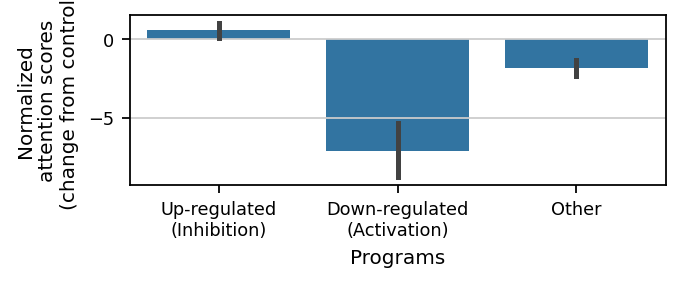

In [42]:
plt.figure(figsize=(4.5,2))
# set font size
sns.barplot(data=grn_df_mean_whole_new, 
            x='group', 
            y='score')
plt.xlabel('Programs', fontsize=9)
plt.ylabel('Normalized\nattention scores\n(change from control)', fontsize=9)
# change font size of ticks
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

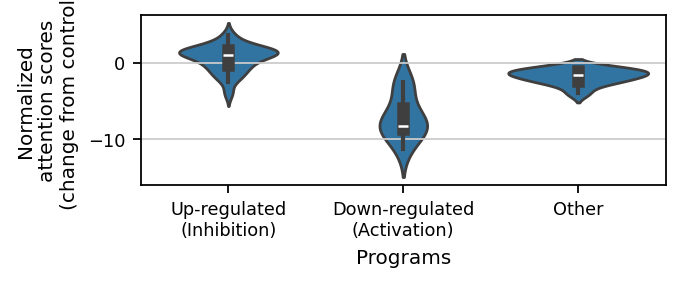

In [43]:
plt.figure(figsize=(4.5, 2))
# set font size
sns.violinplot(data=grn_df_mean_whole_new, 
            x='group', 
            y='score')
plt.xlabel('Programs', fontsize=9)
plt.ylabel('Normalized\nattention scores\n(change from control)', fontsize=9)
# change font size of ticks
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

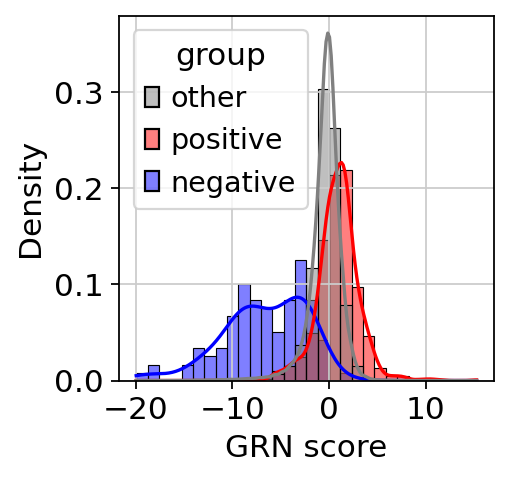

In [44]:
# plot histogram of grn (color by positive)
plt.figure(figsize=(3, 3))
sns.histplot(data=grn_df_whole, x='score', hue='group', kde=True, bins=30, stat='density', common_norm=False, palette=color_dict)
plt.xlabel('GRN score')
plt.ylabel('Density')
plt.show()

In [45]:
program_gene_df_check =  program_gene_df.copy()
program_gene_df_check = program_gene_df_check.T
program_gene_df_check

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
gene_name,,,,,,,,,,,,,,,,,,,,,
LINC01409,1.324107,0.728135,1.324493,-0.329260,-0.164152,-0.172596,-0.550036,1.452994,-0.129932,0.334202,...,-0.408045,-0.025513,-0.168569,-0.009908,0.106220,-0.028575,-0.028646,-0.268132,0.479918,-0.197719
HES4,-0.126163,0.914237,0.342785,0.888810,-0.124565,-0.027131,-0.140766,-0.076127,-0.042811,-0.167578,...,-0.408417,0.227233,-0.204636,1.901711,0.930770,-0.192769,0.098943,-0.000950,0.608101,0.007869
ISG15,-0.119671,1.007041,-0.173688,0.236873,0.997556,-0.495155,1.055347,1.027404,0.975174,-0.259534,...,-0.041706,1.694734,0.485633,0.820917,0.340448,1.317451,-0.295910,-0.043605,0.234885,-0.022814
SDF4,0.706987,0.499833,1.376150,0.886147,0.676954,1.076263,0.964887,1.031888,0.211721,0.400799,...,0.576340,-0.003723,-0.106392,0.634848,0.469329,-0.016525,0.163280,0.651183,1.118678,0.629780
B3GALT6,-0.465301,0.581147,-0.302041,-0.035770,0.343763,0.192373,-0.083702,0.798082,-0.411732,-0.289840,...,0.780025,-0.003171,-0.331698,-0.203099,-0.261513,-0.203910,-0.081149,-0.493861,-0.114938,-0.221710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,3.109789,2.042169,2.585303,1.551697,0.664836,1.513587,-0.162278,0.727187,3.277066,2.390058,...,3.376198,3.376783,0.487409,0.466283,2.172698,1.528710,0.279144,1.877400,1.220297,3.246142
BX004987.1,-0.069540,-0.272759,-0.191486,-0.230655,0.394447,-0.079294,-0.363585,-0.163309,-0.238393,-0.004139,...,0.327064,-0.111495,-0.188192,2.162088,0.317942,0.516871,1.962729,0.346090,0.959098,-0.156417
MAFIP,-0.190746,0.196564,-0.152754,0.786704,1.703664,0.221315,-0.185719,0.156853,-0.182194,-0.176523,...,-0.191529,-0.167618,-0.003516,0.495082,-0.057179,0.439207,-0.080450,-0.160696,-0.347751,0.809933


In [46]:
rest_genes = set(program_gene_df_check.index.str.lower()) - set(gene_cluster['gene_name'].tolist())
gene_cluster_all = pd.concat([gene_cluster, pd.DataFrame({'gene_name': list(rest_genes), 'gene_cluster': 'other'})])
gene_cluster_all

,gene_name,gene_cluster,manual_annotation
0,mt-nd6,0_mitochondrial respiratory chain,mitochondrial respiratory chain
3,mt-nd2,0_mitochondrial respiratory chain,mitochondrial respiratory chain
4,mt-nd5,0_mitochondrial respiratory chain,mitochondrial respiratory chain
5,mt-co1,0_mitochondrial respiratory chain,mitochondrial respiratory chain
6,mt-nd3,0_mitochondrial respiratory chain,mitochondrial respiratory chain
...,...,...,...
4350,mtrf1l,other,NaN
4351,snhg21,other,NaN
4352,slc35a3,other,NaN
4353,ervmer61-1,other,NaN


In [47]:
gene_cluster_all['gene_cluster'].nunique()

31

In [48]:
if 'replogle_k562_essential' in dataset_name or 'replogle_rpe1' in dataset_name:
    gene_cluster_all['gene_cluster'] = gene_cluster_all['gene_cluster'].str.replace(r'^\d+_', '', regex=True)
    # set '' to 'other'
    gene_cluster_all['gene_cluster'] = gene_cluster_all['gene_cluster'].replace('', 'other')

gene_cluster_all['gene_cluster'].nunique()

14

In [49]:
gene_cluster_all['gene_cluster'].value_counts()

gene_cluster
other                                                                4643
erythroid differentiation                                              51
growth signaling                                                       48
dysregulated lncRNA/antisense transcripts                              43
unfolded protein response/mTORC1 signaling                             41
ribosome biogenesis                                                    33
translation                                                            32
unfolded protein response                                              24
oxidative phosphorylation                                              24
cholesterol homeostasis                                                23
proteasome genes                                                       14
mitochondrial respiratory chain                                        11
growth/targets of Myc                                                   8
mitochondrial protein tra

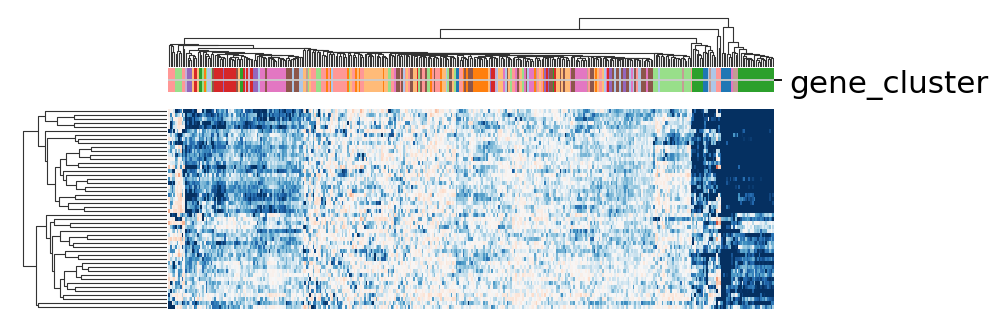

In [50]:
from matplotlib.colors import to_hex

gene_set_temp = gene_cluster_all[gene_cluster_all['gene_cluster'] != 'other']['gene_name'].tolist()
temp_plot = program_gene_df_check.copy()
temp_plot.index = temp_plot.index.str.lower()
temp_plot = temp_plot[temp_plot.index.isin(gene_set_temp)]

# Dynamically create color dict based on gene clusters in gene_cluster_temp
unique_clusters = gene_cluster_all['gene_cluster'].dropna().unique()
# remove 'other' from unique_clusters
unique_clusters = [x for x in unique_clusters if x != 'other']
num_clusters = len(unique_clusters)
if dataset_name == 'replogle_k562_essential':
    palette = sns.color_palette("tab20", 20)
elif dataset_name == 'dixit_bmdc_3hr':
    palette = sns.color_palette("tab10", 10)
palette = palette[:num_clusters]  # Ensure we only have 39 colors
cluster_colors = {cluster: to_hex(color) for cluster, color in zip(unique_clusters, palette)}  # Map clusters to colors
# cluster_colors['other'] = 'white'  # Default color for genes not in specified clusters

row_colors = gene_cluster_all.set_index('gene_name').loc[temp_plot.index, 'gene_cluster'].map(cluster_colors)
row_colors.fillna('gray', inplace=True)

temp_plot = temp_plot.T

# Plot heatmap with column colors
g=sns.clustermap(
    temp_plot,
    cmap='RdBu',
    center = 0,
    vmin = -3,
    vmax = 3,
    col_cluster=True,
    row_cluster=True,
    col_colors=row_colors,
    xticklabels=False,
    yticklabels=False,
    figsize=(6.5, 2.5)
)

# Enlarge column color bar
g.ax_col_colors.set_position([g.ax_col_colors.get_position().x0, 
                              g.ax_col_colors.get_position().y0, 
                              g.ax_col_colors.get_position().width, 
                              g.ax_col_colors.get_position().height * 3])  # Increase height

if g.ax_row_colors:
    g.ax_row_colors.set_axis_off()  # Turn off the axis completely
g.cax.set_visible(False)
# remove y labels
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
# plt.title('Program to Gene Mapping')
plt.show()

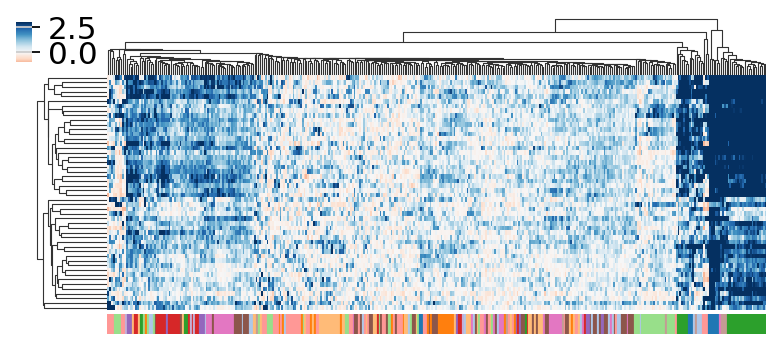

In [51]:
from matplotlib.colors import to_hex
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

# Filter genes based on the desired clusters
gene_set_temp = gene_cluster_all[gene_cluster_all['gene_cluster'] != 'other']['gene_name'].tolist()
temp_plot = program_gene_df_check.copy()
temp_plot.index = temp_plot.index.str.lower()
temp_plot = temp_plot[temp_plot.index.isin(gene_set_temp)]

# Dynamically create color dict based on gene clusters in gene_cluster_all
unique_clusters = gene_cluster_all['gene_cluster'].dropna().unique()
# remove 'other' from unique_clusters
unique_clusters = [x for x in unique_clusters if x != 'other']
num_clusters = len(unique_clusters)
if dataset_name == 'replogle_k562_essential':
    palette = sns.color_palette("tab20", 20)
    shift = 0
    palette = palette[shift:num_clusters+shift]  # Ensure we only have 39 colors
elif dataset_name == 'dixit_bmdc_3hr':
    palette = sns.color_palette("tab10", 10)
    palette = palette[:num_clusters]  # Ensure we only have 39 colors
cluster_colors = {cluster: to_hex(color) for cluster, color in zip(unique_clusters, palette)}  # Map clusters to colors
# cluster_colors['other'] = 'grey'  # Default color for genes not in specified clusters

col_colors = gene_cluster_all.set_index('gene_name').loc[temp_plot.index, 'gene_cluster'].map(cluster_colors)
col_colors.fillna('gray', inplace=True)

temp_plot = temp_plot.T

# Plot heatmap with column colors
g=sns.clustermap(
    temp_plot,
    cmap='RdBu',
    center = 0,
    vmin = -1,
    vmax = 3,
    col_cluster=True,
    row_cluster=True,
    # col_colors=col_colors,
    xticklabels=False,
    yticklabels=False,
    figsize=(5, 2.5),
    dendrogram_ratio=(0.1, 0.2),  # Space for dendrogram
    cbar_pos=(0.02, 0.8, 0.02, 0.1)  # Adjusted color bar size (X, Y, Width, Height)
)


# Get the reordered column indices from the clustering
col_order = g.dendrogram_col.reordered_ind
col_colors_sorted = col_colors.iloc[col_order]

# Create a new axes for the column colors just below the heatmap
heatmap_ax = g.ax_heatmap  # Get the heatmap axis
colorbar_ax = heatmap_ax.figure.add_axes([
    heatmap_ax.get_position().x0,  # x start
    heatmap_ax.get_position().y0 - 0.06,  # Attach just below heatmap
    heatmap_ax.get_position().width,  # Same width as heatmap
    0.05  # Height of color bar
])

# Manually add colored rectangles
patches = []
for i, color in enumerate(col_colors_sorted):
    rect = mpatches.Rectangle((i, 0), 1, 1, color=color)
    patches.append(rect)

collection = PatchCollection(patches, match_original=True)
colorbar_ax.add_collection(collection)

# Remove ticks and labels
colorbar_ax.set_xlim(0, len(col_colors_sorted))
colorbar_ax.set_ylim(0, 1)
colorbar_ax.set_xticks([])
colorbar_ax.set_yticks([])
colorbar_ax.axis("off")

# remove y labels
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')

plt.show()